Using TensorFlow backend.


skipping line: ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
len steer 8036
-0.9426954: 2
-0.9332381: 1
-0.9237437: 1
-0.8098114: 1
-0.771834: 1
-0.7243622: 1
-0.6863848: 2
-0.6294187: 2
-0.6009356: 2
-0.5344751: 1
-0.5249807: 2
-0.505992: 8
-0.4964977: 6
-0.4775089: 1
-0.4680146: 2
-0.4585202: 1
-0.4490258: 17
-0.4395315: 12
-0.4300371: 1
-0.4205428: 4
-0.4110484: 15
-0.401554: 3
-0.3920597: 10
-0.3825653: 8
-0.373071: 10
-0.3540823: 9
-0.3445879: 4
-0.3350936: 5
-0.3255992: 9
-0.3161048: 14
-0.3066105: 9
-0.2971161: 43
-0.2876218: 38
-0.2781274: 31
-0.2686331: 18
-0.2591387: 10
-0.2496443: 11
-0.24015: 9
-0.2306556: 36
-0.2211613: 41
-0.2116669: 56
-0.2021725: 7
-0.1926782: 8
-0.1831838: 16
-0.1736895: 20
-0.1641951: 36
-0.1547008: 49
-0.1452064: 179
-0.135712: 51
-0.1262177: 26
-0.1167233: 55
-0.107229: 33
-0.09773462: 23
-0.08824026: 80
-0.0787459: 150
-0.06925154: 129
-0.05975719: 152
-0.05026283: 61
-0.04076847: 46
-0.03127411: 38
-0.02177976: 49
-0.012285

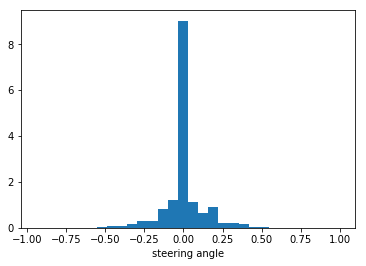

In [1]:
import csv
import cv2
import keras
import numpy as np
import sklearn

from keras.models import Sequential
from keras.layers import Flatten, Dense, Input, Lambda, Conv2D, MaxPooling2D, Dropout, Activation, Cropping2D
from keras.callbacks import History 


k_prob =0.25
EPOCHS = 1
BATCH_SIZE = 16
VALID_SIZE_RATIO = 0.1
TEST = 0
LOAD = 0
LOAD_MODEL = 'model_nvidia_lin_e2.h5'
SAVE_MODEL = 'model_nvidia_prep_lin_test.h5'


history = History()

samples_00 = []  # samples of steering angle         n == 0
samples_02 = []  # samples of steering angle     0 < n <= 0.25
samples_12 = []  # samples of steering angle -0.25 < n <= 0
samples_99 = []  # samples of steering angle outside of the above
steer      = []  # 
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if(line[0] == 'center'):
            print("skipping line:", line)
        else:
            if(float(line[3]) == 0):
                samples_00.append(line)
            elif(float(line[3]) > 0 and float(line[3]) <= 0.25):
                samples_02.append(line)
            elif(float(line[3]) < 0 and float(line[3]) >= -0.25):
                samples_12.append(line)
            else:
                samples_99.append(line)
            steer.append(float(line[3]))

u_steer, u_cnt = np.unique(steer, return_counts=True)
print("len steer", len(steer))
print(*(map('{}: {}'.format, u_steer, u_cnt)), sep="\n")

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.hist(steer, normed=True, bins=30)
plt.xlabel('steering angle');

print("len samples_00", len(samples_00))
print("len samples_02", len(samples_02))
print("len samples_12", len(samples_12))
print("len samples_99", len(samples_99))

len bal_samples_00 130
len bal_samples_02 313
len bal_samples_12 279
len     samples_99 636
len samples 1358


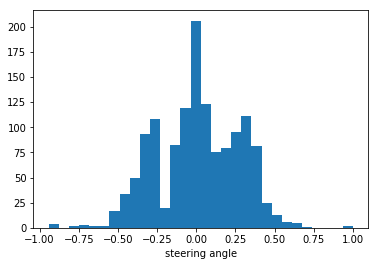

In [2]:
import random
from random import shuffle

def down_sample_size(samples, target_size):
    random.shuffle(samples)
    return samples[0:target_size]

DROP_ZERO_RATIO = 0.97  #0.98
DROP_PT_2_RATIO = 0.80  #0.75
DROP_PTN2_RATIO = 0.81  #0.76

bal_samples_00 = down_sample_size(samples_00, int(len(samples_00)*(1-DROP_ZERO_RATIO)))
bal_samples_02 = down_sample_size(samples_02, int(len(samples_02)*(1-DROP_PT_2_RATIO)))
bal_samples_12 = down_sample_size(samples_12, int(len(samples_12)*(1-DROP_PTN2_RATIO)))

print("len bal_samples_00", len(bal_samples_00))
print("len bal_samples_02", len(bal_samples_02))
print("len bal_samples_12", len(bal_samples_12))
print("len     samples_99", len(samples_99))

samples = []
for sam in bal_samples_00:
    samples.append(sam)
for sam in bal_samples_02:
    samples.append(sam)
for sam in bal_samples_12:
    samples.append(sam)
for sam in samples_99:
    samples.append(sam)

random.shuffle(samples)
print("len samples", len(samples))

steer = []
for line in samples:
    steer.append(float(line[3]))

plt.hist(steer, normed=False, bins=30)
plt.xlabel('steering angle');


In [3]:
'''
samples = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if(line[0] == 'center'):
            print("skipping line:", line)
        else:
            samples.append(line)
'''

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=VALID_SIZE_RATIO)

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = 'data/IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                flip_image = cv2.flip(center_image, 1)
                name = 'data/IMG/'+batch_sample[1].split('/')[-1]
                left_image = cv2.imread(name)
                name = 'data/IMG/'+batch_sample[2].split('/')[-1]
                right_image = cv2.imread(name)
                center_angle = float(batch_sample[3])

                images.append(center_image)
                angles.append(center_angle)
                images.append(flip_image)
                angles.append(center_angle*-1.0)
                images.append(left_image)
                #angles.append(center_angle+0.25)
                angles.append(center_angle+((1-abs(center_angle))*0.25))
                images.append(right_image)
                #angles.append(center_angle-0.25)
                angles.append(center_angle-((1-abs(center_angle))*0.25))

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            
            if(TEST==1):
                plt.hist(angles, normed=False, bins=30)
                plt.xlabel('steering angle');

                print("X_train",X_train.shape)
                print("y_train",y_train.shape)
                #print("X_train",X_train[:2])
                #print("y_train",y_train[:30])

            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=BATCH_SIZE)
validation_generator = generator(validation_samples, batch_size=BATCH_SIZE)



'''
lines = []
datapath = 'data'
#windows \
#linux /
print("reading from file", datapath + '/driving_log.csv')
with open(datapath + '/driving_log.csv') as csvfile:
    #print(datapath + '/driving_log.csv')
    reader = csv.reader(csvfile)
    for line in reader:
        if(line[0] == 'center'):
            print("skipping line:", line)
        else:
            lines.append(line)

images = []
measurements = []
steering = []
throttle = []
break_   = []
speed    = []
CV_LOAD_IMAGE_COLOR=1
image_path = []

i=0
# line contains a list of the following elements
# center image path, left image path, right image path, steering angel, throttle, break, speed
for line in lines:
    for k in range(0,3):
        #print("k", k)
        source_path = line[k]
        #windows \
        #linux /
        filename = source_path.split('/')[-1]
        image_path.append(datapath + "/IMG/" + filename)
        
    #print(image_path)
    image_center = cv2.imread(image_path[0],CV_LOAD_IMAGE_COLOR)
    image_left   = cv2.imread(image_path[1],CV_LOAD_IMAGE_COLOR)
    image_right  = cv2.imread(image_path[2],CV_LOAD_IMAGE_COLOR)
    
    #print(image)
    if (image_center is None or image_left is None or image_right is None):
        print("Error loading image[",i,"] ================> NoneType")
        break
    else:
        #print("image[",i,"].shape", image.shape)
        steering = float(line[3])
        #print("steering=", steering)
        throttle = float(line[4])
        break_   = float(line[5])
        speed    = float(line[6])
    
        # process center image
        images.append(image_center)
        measurements.append(steering)

        # flip center image
        images.append(cv2.flip(image_center, 1))   # adding flipped image
        measurements.append(steering*(-1.0))# adding flipped steering angel
        #print("steering*-1.0",steering*(-1.0) )
        
        # process left image, +0.2 to steering
        images.append(image_left)   # adding flipped image
        measurements.append(steering+0.4)   # adding flipped steering angel

        # process right image, -0.2 to steering
        images.append(image_right)   # adding flipped image
        measurements.append(steering-0.4)   # adding flipped steering angel
        
    i+=1

    #==============================================================================
    #this is just for testing the code
    #if (i==100):
    #    break
    #==============================================================================
'''
#print("images[:1]", images[:2])

#X_train = np.array(images)
#y_train = np.array(measurements)


#print("X_train",X_train.shape)
#print("y_train",y_train.shape)
#print("X_train",X_train[:2])
#print("y_train",y_train[20:300])

import matplotlib.pyplot as plt
#plt.figure(figsize=(2,2))
#plt.imshow(X_train[0], cmap="gray")

print("before model")

if (LOAD==1):
    model = keras.models.load_model(LOAD_MODEL)
else:
    model = Sequential()
    #normalizing input data
    model.add(Lambda(lambda x: (x/255.0)-0.5, input_shape=(160,320,3)))

    #crop out top and bottom pixels to reduce noise from sky and hood
    model.add(Cropping2D(cropping=((70,25), (0,0))))

    if(TEST==1):
        #model.add(Flatten())  # size of 2496
        #model.add(Dense(1))
        print("skip model")
    else:
        model.add(Conv2D(16, kernel_size=(5,5), activation='relu')) # 45x320x3  -> 41x316x24 -> 20x158x24
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Conv2D(24, kernel_size=(5,5), activation='relu')) # 20x158x24 -> 16x154x36 -> 8x77x36
        model.add(Conv2D(36, kernel_size=(5,5), activation='relu')) # 8x77x36   -> 6x73x48   -> 3x36x48
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(k_prob))
        model.add(Conv2D(48, kernel_size=(3,3), activation='relu')) # 3x36x48   -> 1x34x48
        model.add(Dropout(k_prob))
        model.add(Conv2D(64, kernel_size=(3,3), activation='relu')) # 
        model.add(Dropout(k_prob))
        model.add(Flatten())  # size of 2496
        model.add(Dense(256))
        model.add(Dense(100))
        model.add(Dense(10))
        model.add(Dense(1)) #adding softmax activation at the last layer seems to cause steering stuck at 1 or right turn

    model.compile(loss='mse', 
                  optimizer='adam')

'''
history_object = model.fit(X_train, y_train, 
          validation_split=0.2, 
          shuffle=True, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE,
          callbacks=[history],
          verbose=1)
'''
print("before model fit")
history_object = model.fit_generator(train_generator, 
                                     steps_per_epoch=len(train_samples), 
                                     validation_data=validation_generator,
                                     validation_steps=len(validation_samples), 
                                     epochs=EPOCHS,
                                     callbacks=[history],
                                     verbose=1)

print("before model save")
model.save(SAVE_MODEL)
print("written to ", SAVE_MODEL)


before model
before model fit
Epoch 1/1
1222/1222 [==============================] - 2558s - loss: 0.0470 - val_loss: 0.0301
before model save
written to  model_nvidia_prep_lin_test.h5


dict_keys(['val_loss', 'loss'])


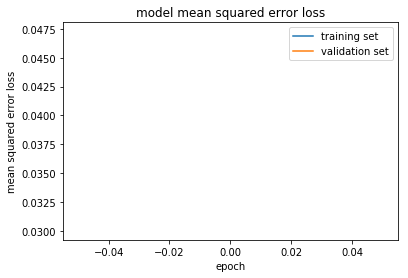

In [7]:
'''
from keras.models import Model
import matplotlib.pyplot as plt

history_object = model.fit_generator(train_generator, 
                                     samples_per_epoch=25715 , #samples_per_epoch=len(train_samples), 
                                     validation_data=validation_generator,
                                     nb_val_samples=6429 , #nb_val_samples=len(validation_samples), 
                                     epoch=1,
                                     verbose=1)
'''
### print the keys contained in the history object
print(history_object.history.keys())
print(history_object)

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()